# Bayesian Linear Regression with Metropolis-Hastings

Bayesian formulation of Linear Regression: 
$$
Y | X \sim \mathcal{N}(w^T X, \sigma^2 I)
$$

The  model is now defined as a posterior probabilisic distribution, found by combining the prior and the likelihood from training data:
$$
p(w | X, y) = \frac{p(y,X | w) p(w)}{p(y, X)}
$$

Since we may not be able to directly compute the posterior, we use a sampling method, such as Monte Carlo Markov Chain (MCMC) to sample from the posterior distribution.

### Metropolis-Hastings

1. Inizialize $w^{(1)}$ to some value

2. For $t = 1, \dots, T$:
    1. Sample $w'$ from a proposal distribution $q(w' | w^{(t-1)})$
    2. Compute the acceptance ratio $\alpha = min(1,\frac{p(w'| X, y)}{p(w^{(t-1)} | X, y)}\frac{q(w^{(t-1)}|w')}{q(w'|w^{(t-1)})} )$
    3. Sample $u \sim \mathcal{U}(0,1)$
    4. If $u < \alpha$, set $w^{(t)} = w^*$, otherwise set $w^{(t)} = w^{(t-1)}$


Simplifying assumption: by making use of a symmetric distribution for the proposal distribution, we can simplify the acceptance ratio such that $$\frac{q(w^{(t-1)}|w')}{q(w'|w^{(t-1)})} = 1$$ and $$\alpha = min(1,\frac{p(w'| X, y)}{p(w^{(t-1)} | X, y)})$$. In this case a Gaussian distribution is used for the proposal distribution.

### Proposal distribution

As a proposal distribution for w, we use a Gaussian distribution with mean $w^{(t-1)}$ and covariance matrix $k^2 I$, such that
$$
w' \sim \mathcal{N}(w^{(t-1)}, k^2 I)
$$

### Acceptance ratio

We can substitute the posterior distribution into the acceptance ratio, knowing that  $$p(w^{(t-1)} | X, y) = \frac{p(y,X | w^{(t-1)}) p(w^{(t-1)})}{p(y, X)}$$ and $$p(w' | X, y) = \frac{p(y,X | w') p(w')}{p(y, X)}$$

such that the acceptance ratio becomes
$$
\alpha = min(1,\frac{p(y,X | w') p(w')}{p(y,X | w^{(t-1)}) p(w^{(t-1)})})
$$

For numerical stability, we can take the log of the acceptance ratio, such that
$$
\log(\alpha)  = min(0,\log(p(y,X | w') p(w')) - \log(p(y,X | w^{(t-1)}) p(w^{(t-1)}))) = \\
= min(0,\log(p(y,X | w')) + \log(p(w')) - \log(p(y,X | w^{(t-1)}) - \log(p(w^{(t-1)}))))
$$
The probability of proposal acceptance will be then computed as the exponential of $log(\alpha)$.

The likelihood density can be rewritten assuming independence between the data points and using the Gaussian distribution for the likelihood:
$$
y | X, w \sim \mathcal{N}(X w, \sigma^2 I)
$$, therefore
$$
p(y,X | w) = \prod_{i=1}^N \mathcal{N}(y_i | w^T x_i, \sigma^2)
$$

For the prior, we use a Gaussian distribution with mean 0 and covariance matrix $\tau^2 I$, such that
$$
p(w) = \mathcal{N}(w | 0, \tau^2 I)
$$


## Implementation

In [13]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import scipy.stats as sc

In [2]:
def proposal(mean, std):
    """Proposal distribution for the Metropolis-Hastings algorithm, 
        returning a sample from a multivariate Gaussian."""
    return sc.multivariate_normal(mean=mean, cov=np.eye(2)*std**2).rvs(1)

def prior(w, prior_mean, prior_cov):
    """Prior distribution for the model parameters"""
    prior_out = sc.multivariate_normal.logpdf(w,mean=prior_mean,cov=prior_cov,allow_singular=True)
    return prior_out

def likelihood(w, x, y, sigma):
    """Likelihood function for the model parameters"""
    likelihood_out = np.sum(sc.norm.logpdf(y,loc=np.dot(x,w),scale=sigma))
    return likelihood_out
    

In [3]:
def metropolis_hastings(num_steps, x,y, mean, cov, sigma ,proposal_std,burn_in=0):
    """Metropolis-Hastings algorithm for sampling from a posterior distribution
    
    Parameters
    ----------
    num_steps : int
        Number of steps to run the algorithm for
    x : numpy.ndarray
        Training data inputs
    y : numpy.ndarray
        Training data targets
    mean : numpy.ndarray
        Mean of the prior distribution for the model parameters
    cov : numpy.ndarray
        Covariance matrix of the prior distribution for the model parameters
    sigma : float
        Standard deviation of the likelihood function for the model parameters
    proposal_std : float
        Standard deviation of the proposal distribution for the model parameters
    burn_in : float
        Fraction of the samples to discard as burn-in
    """
    
    samples = np.zeros((num_steps, 2))
    samples[0] = np.random.uniform(-1, 1, 2) # initialize the first sample
    accept_count = 0
    for i in range(1, num_steps):
        new_sample = proposal(samples[i-1], proposal_std)
       
        #Compute the acceptance probability
        log_prior_new = prior(new_sample, mean, cov)
        log_prior_old = prior(samples[i-1], mean, cov)
        log_likelihood_new = likelihood(new_sample, x, y, sigma)
        log_likelihood_old = likelihood(samples[i-1], x, y, sigma)
        proposal_ratio = np.exp(log_prior_new + log_likelihood_new - log_prior_old - log_likelihood_old)

        accep_p = min(1, proposal_ratio)
                
        # accept or reject the new sample
        if np.random.uniform(0, 1) < accep_p:
            samples[i] = new_sample
            if (i > int(burn_in*num_steps)):
                accept_count += 1
        else:
            samples[i] = samples[i-1]

    accept_rate = np.around(accept_count / num_steps, 3)
    return samples, accept_rate

### Build dataset

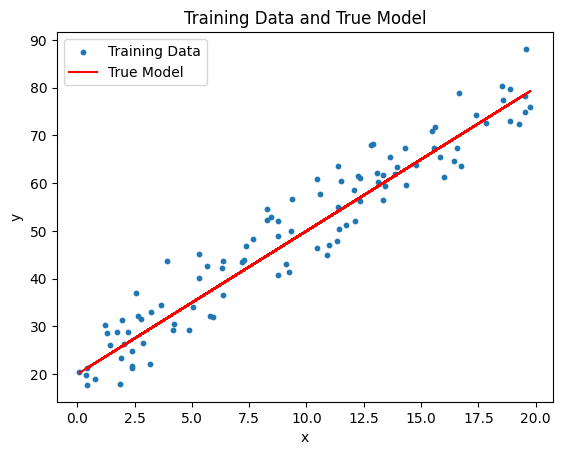

In [4]:
np.random.seed(0)

true_w = np.array([3.0,20.0])
true_sigma = 5.0

dataset_size = 100

x  = np.random.uniform(0,20,dataset_size)
x  = np.vstack((x,np.ones(dataset_size))).T
y  =  x @ true_w + np.random.normal(0,true_sigma,dataset_size)

plt.scatter(x[:,0],y,s=10,label='Training Data')
plt.plot(x[:,0],x@ true_w,'r',label='True Model')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training Data and True Model')
plt.legend()
plt.show()

<em>proposal_std</em> tunes the chains convergence times: if it is too small the acceptance rate will be high, but successive samples will move around the space slowly, and the chain will converge  slowly to the posterior distribution. On the other hand, if it is too large, the acceptance rate will be very low because the proposals are likely to land in regions of much lower probability density and again the chain will converge very slowly

In [5]:
N = 20000 # number of steps to run the algorithm for
burn_in = 0.4
proposal_std = 0.5 # standard deviation of the proposal distribution
prior_mean = np.zeros(2)
prior_cov = np.eye(2)*10

samples, rate = metropolis_hastings(N, x,y, prior_mean, prior_cov, true_sigma, proposal_std, burn_in)


/var/folders/9x/8pf4wzp525g1tb_68dffg4_40000gn/T/ipykernel_3084/1012029628.py:35: RuntimeWarning: overflow encountered in exp
  proposal_ratio = np.exp(log_prior_new + log_likelihood_new - log_prior_old - log_likelihood_old)


### Results

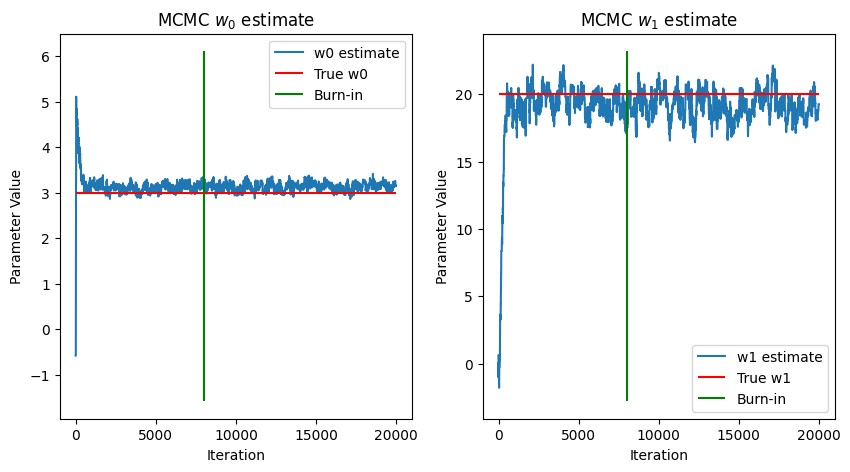

In [6]:
fig,axs=plt.subplots(1,2, figsize=(10,5))
axs[0].plot(samples[:,0], label='w0 estimate')
axs[0].hlines(y=true_w[0], xmin=0, xmax=N, color='r', label='True w0')
axs[0].vlines(x=int(burn_in*N), ymin=min(samples[:,0])-1, ymax=max(samples[:,0])+1, color='g', label='Burn-in')
axs[0].legend()
axs[0].set_title('MCMC $w_0$ estimate')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Parameter Value')


axs[1].plot(samples[:,1], label='w1 estimate')
axs[1].hlines(y=true_w[1], xmin=0, xmax=N, color='r', label='True w1')
axs[1].vlines(x=int(burn_in*N), ymin=min(samples[:,1])-1, ymax=max(samples[:,1])+1, color='g', label='Burn-in')
axs[1].legend()
axs[1].set_title('MCMC $w_1$ estimate')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Parameter Value')
plt.show()

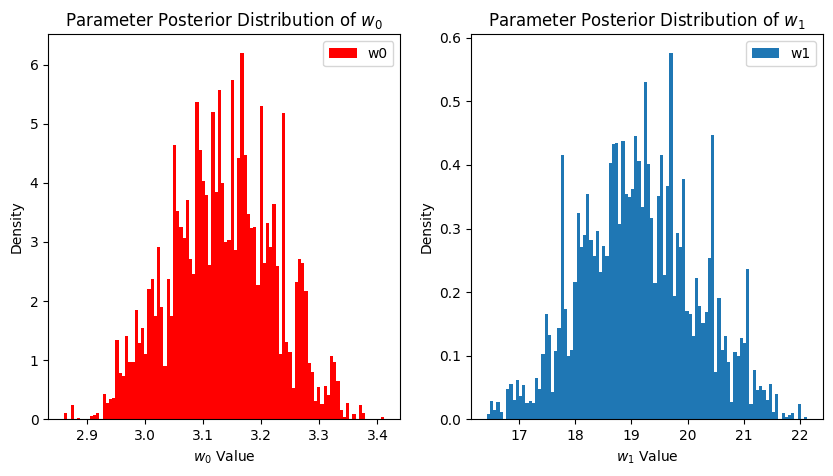

In [7]:
samples_post_burnin = samples[int(burn_in*N):]

fig,axs=plt.subplots(1,2, figsize=(10,5))
axs[0].hist(samples_post_burnin[:,0], bins=100, density=True, label='w0', color='r')
axs[1].hist(samples_post_burnin[:,1], bins=100, density=True, label='w1')
axs[0].set_xlabel('$w_{0}$ Value')
axs[0].set_ylabel('Density')
axs[1].set_xlabel('$w_{1}$ Value')
axs[1].set_ylabel('Density')
axs[0].set_title('Parameter Posterior Distribution of $w_{0}$')
axs[1].set_title('Parameter Posterior Distribution of $w_{1}$')
axs[0].legend()
axs[1].legend()

In [8]:
# Evaluation of mean and standard deviation of the inferred parameters
w0_mean = np.mean(samples_post_burnin[:,0])
w1_mean = np.mean(samples_post_burnin[:,1])
w0_std = np.std(samples_post_burnin[:,0])
w1_std = np.std(samples_post_burnin[:,1])
print('w0 mean: {:.2f}'.format(w0_mean))
print('w1 mean: {:.2f}'.format(w1_mean))
print('w0 std: {:.2f}'.format(w0_std))
print('w1 std: {:.2f}'.format(w1_std))


w0 mean: 3.13
w1 mean: 19.15
w0 std: 0.09
w1 std: 1.01


Estimated w:  [ 3.13437179 19.15485798]


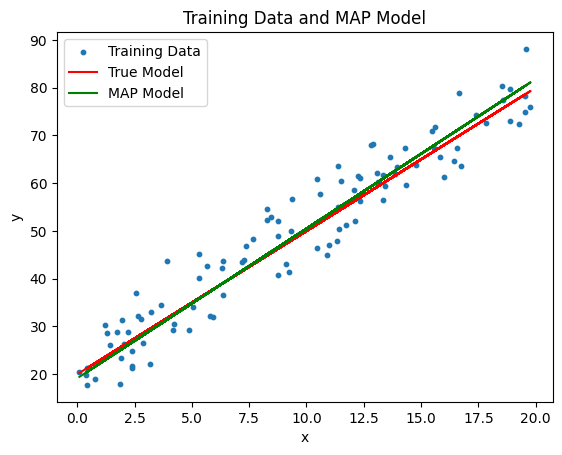

In [11]:
# Compute the MAP estimate (computed as the mean of the samples after burn-in)
w_est = np.mean(samples_post_burnin,axis=0)
print('Estimated w: ',w_est)

plt.scatter(x[:,0],y,s=10,label='Training Data')
plt.plot(x[:,0],x@ true_w,'r',label='True Model')
plt.plot(x[:,0],x@ w_est,'g',label='MAP Model')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training Data and MAP Model')
plt.legend()
plt.show()

#### Metropolis-Hastings' convergence

MovieWriter - unavailable; using Pillow instead.


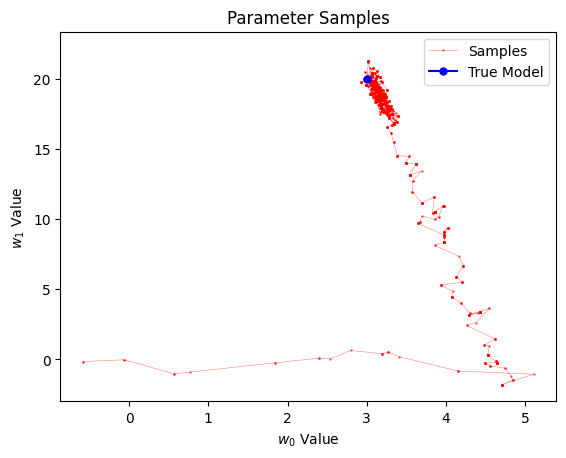

In [12]:
fig, ax = plt.subplots()
scatter, = ax.plot(samples[:,0], samples[:,1], linewidth=0.4, marker='o', markersize=0.8, color='r', alpha=0.5,label='Samples')
ax.plot(true_w[0], true_w[1], marker='o', markersize=5, color='b', label='True Model')
ax.set_title('Parameters\' Samples')
ax.set_xlabel('$w_{0}$ Value')
ax.set_ylabel('$w_{1}$ Value')
ax.legend()

def update(num, samples, scatter):
    scatter.set_data(samples[:num,0], samples[:num,1])
    return scatter,

ani = animation.FuncAnimation(fig=fig, func=update, frames=int(samples.shape[0]/10), interval=1, 
                              fargs=[samples, scatter], blit=True)
ani.save('mh.gif', writer='-', fps=60)

### References

- [Mastering Bayesian Linear Regression from Scratch: A Metropolis-Hastings Implementation in Python](https://medium.com/@tinonucera/bayesian-linear-regression-from-scratch-a-metropolis-hastings-implementation-63526857f191).
- [Interactive Bayesian Linear Regression with Metropolis-Hastings](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/Interactive_Bayesian_Linear_Regression.ipynb)